In [ ]:
:ext OverloadedStrings

In [ ]:
import Data.List (find)
import qualified Data.List.NonEmpty as N
import Data.List.NonEmpty (NonEmpty((:|)))
import Data.Heap (Heap)
import qualified Data.Heap as Heap
import qualified Data.Map as Map
import qualified Data.Set as Set

In [ ]:
import qualified Graphics.Vega.VegaLite as VL
import Graphics.Vega.VegaLite hiding (filter)

In [ ]:
:!ghc-pkg latest ghc
:!ghc-pkg latest ihaskell
:!ghc-pkg latest hvega
:!ghc-pkg latest ihaskell-hvega

In [ ]:
import Routing.Lib (Node, AList, makeDGraph, generateDijkstra, spDijkstra)
import Routing.Osm (coords, queryEdges, queryNodes, unOsmEdge)
import Database.PostgreSQL.Simple

In [ ]:
missionCliffs, planetGranite :: Node
missionCliffs = 65286435
planetGranite = 7273409084

In [ ]:
import Control.Monad.Reader

connectTestDb = connectPostgreSQL
  "postgresql:///pgsnapshot?host=/home/matt/src/routing-playground/osm/postgres"

withTestDb :: ReaderT Connection IO a -> IO a
withTestDb r = connectTestDb >>= \testDb -> runReaderT r testDb

In [ ]:
spData :: Node -> Node -> IO ([DataColumn] -> Data)
spData orig dest = withTestDb $ do
  es <- queryEdges
  let graph = makeDGraph $ fmap unOsmEdge es
      Just (_, path) = spDijkstra orig dest graph
  ns <- queryNodes path
  let nm = Map.fromList ns
      ordered = fmap (nm Map.!) path
      pathCoords = fmap coords ordered
      xs = fmap fst pathCoords
      ys = fmap snd pathCoords
      dat = dataFromColumns []
          . dataColumn "ord" (Numbers $ fmap fromIntegral [1 .. length ns])
          . dataColumn "lat" (Numbers ys)
          . dataColumn "lng" (Numbers xs)
  return dat

In [ ]:
spData missionCliffs planetGranite >>= \path ->
    let base = dataFromUrl "https://gist.githubusercontent.com/zachmargolis/374a267e8c9a66cc4152/raw/f1b6193b6ec7e20640ecbe900a78e2c097891573/sfshore.json" [TopojsonFeature "sfshore"]
        layerBase = [base, mark Geoshape [MFill "lightgray", MStroke "white"]]
        encLoc = encoding
               . position X [PName "lng", PmType Quantitative, PScale [SDomain (DNumbers [-122.525, -122.35])]]
               . position Y [PName "lat", PmType Quantitative, PScale [SDomain (DNumbers [37.694, 37.815])]]
               . order [OName "ord"]
        layerPath = [path [], encLoc [], mark Line []]
        scatter = toVegaLite [ description ""
                             , width 500
                             , height 500
                             , layer (map asSpec [layerBase, layerPath])]
      in return $ vlShow scatter

In [ ]:
spData' :: Node -> Node -> IO ([DataColumn] -> Data, [DataColumn] -> Data)
spData' o d = withTestDb $ do
  es <- queryEdges
  let graph = makeDGraph $ fmap unOsmEdge es
      (ps, sp@(_, ns) : _) = break (\(_, x :| _) -> x == d)
                           $ generateDijkstra graph (Heap.singleton (0, o :| [])) Set.empty
      allNodes = sp : ps >>= N.toList . snd
      
  nd <- queryNodes allNodes
  
  let nm = Map.fromList nd
      path =
        let ordered = (nm Map.!) <$> N.toList ns
            pathCoords = fmap coords ordered
            xs = fmap fst pathCoords
            ys = fmap snd pathCoords
        in  dataFromColumns []
          . dataColumn "ord" (Numbers $ fmap fromIntegral [1 .. length ns])
          . dataColumn "lat" (Numbers ys)
          . dataColumn "lng" (Numbers xs)
      visited = 
        let nodeCoords = fmap (coords . snd) nd
            xs = fmap fst nodeCoords
            ys = fmap snd nodeCoords
        in  dataFromColumns []
          . dataColumn "lat" (Numbers ys)
          . dataColumn "lng" (Numbers xs)
          
  return (path, visited)

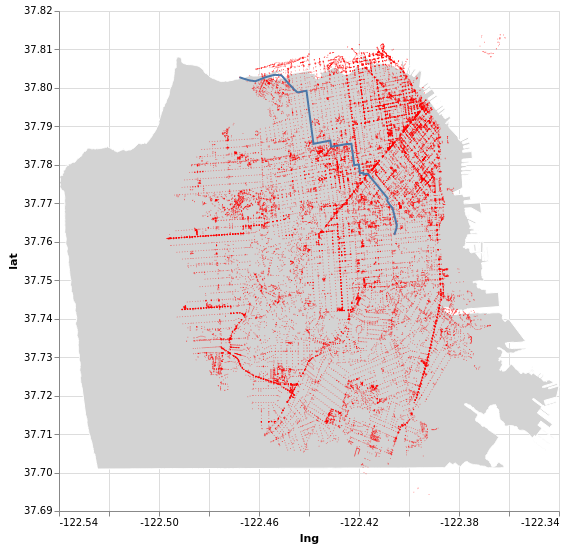

In [11]:
spData' missionCliffs planetGranite >>= \(sp, nodes) ->
    let base = dataFromUrl "https://gist.githubusercontent.com/zachmargolis/374a267e8c9a66cc4152/raw/f1b6193b6ec7e20640ecbe900a78e2c097891573/sfshore.json" [TopojsonFeature "sfshore"]
        layerBase = [base, mark Geoshape [MFill "lightgray", MStroke "white"]]
        -- proj = projection [PType Albers]
        encLoc = encoding
               . position X [PName "lng", PmType Quantitative, PScale [SDomain (DNumbers [-122.525, -122.35])]]
               . position Y [PName "lat", PmType Quantitative, PScale [SDomain (DNumbers [37.694, 37.815])]]
               . order [OName "ord"]
        layerPath = [sp [], encLoc [], mark Line []]
        layerNodes = [nodes [], encLoc [], mark Circle [MColor "red", MSize 1, MOpacity 0.5]]
        scatter = toVegaLite [ description ""
                             , width 500
                             , height 500
                             --, proj
                             , layer (map asSpec [layerBase, layerNodes, layerPath])]
    in return $ vlShow scatter